# Modeling timeseries data in MXNet: using LSTM to predict AWS spot instance price

# Problem

Amazon EC2 Spot instances allow you to bid on spare Amazon EC2 computing capacity. Since Spot instances are often available at a discount compared to On-Demand pricing, you can significantly reduce the cost of running your applications. In this tutorial we will build a neural network that models time series data to predict the price of an instance in the Amazon EC2 Spot market. By predicting the price, you may be able to make smart decisions on when to launch your spot jobs.

To simplify the prediction of spot prices, we'll assume the cost at any previous timestep in time to be dependent on previous values. This may not be entirely true but for simplicity we'll assume so and convert the data in to a timeseries sequence. Ultimately we will train a variant of Recurrent Neural Network called [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) on AWS Spot dataset to build a neural network that can predict the price of an instance in the next timestep.

Click to learn more about [AWS Spot](https://aws.amazon.com/ec2/spot/pricing/)

# Recurrent Neural Networks (RNN)

Certain problems require you to model information dependency, for example take the construction of a sentence. Now these dependencies can be external or could be based on previous context. We'll explore the latter in this notebook. Recurrent neural networks (RNN) are designed to address this issue. They are networks with loops in them, thus allowing information to persist, making them ideal to model sequences. Speech recognition, image captioning, video analysis, language modeling and many other use case can be addressed using RNNs. Check out Andrej Karapthy's [blog](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) for more details. Lets visualize a few examples of sequence in input or oputput: 

![rnn](http://karpathy.github.io/assets/rnn/diags.jpeg)
<sub> img src: http://karpathy.github.io

A RNN can be imagined as a repeated copy of the same network, each passing a message to the next step, in this case it may be to the same layer. But RNNs have problems with long range dependencies - interactions between sequences that are many steps apart, this is explained in detail in this [blog](http://colah.github.io/posts/2015-08-Understanding-LSTMs/). Also RNNs tend to be deep, that is in the temporal direction and hence more vulnerable to the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

To address these issues [Hochreiter & Schmidhuber (1997)](http://www.bioinf.jku.at/publications/older/2604.pdf) introduced LSTMs, which now are widely used to model the problems described above. 


# What is Long Short-Term Memory (LSTM) ?

The Long Short-Term Memory network (LSTM), is a Recurrent Neural Network (RNN) capable of learning long-term dependencies. Instead of neurons, LSTM networks have memory blocks thus making it "smarter" given that it can store recent sequences. These LSTM blocks are are connected through layers. Each block contains three multiplicative gates that govern what information enters the cell, what information exits the cell, and whether or not to discard information discard information stored at previous time steps. The gates are illustriated below: 

![memory cell](http://deeplearning.net/tutorial/_images/lstm_memorycell.png) 
<sub> img src: http://deeplearning.net/tutorial/_images/lstm_memorycell.png


### Training LSTM's

These networks are trained using backpropagation by unrolling in the time dimension. This is necessary given that LSTMs still have a self loop. The unrolling reveals a chain like nature as shown below. This infact makes them very suitable for learning sequences.

![lstm](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)
<sub> img src: http://colah.github.io/posts/2015-08-Understanding-LSTMs



# Prerequisites

Familiarity with MXNet, Python, Pandas, Numpy, basics of LSTM networks. It's recommended that you know the basics of RNNs and LSTMs to proceed.

To complete this tutorial, you need:
- [MXNet](http://mxnet.io) version 0.10+
- Python 2.7 or greater and the following libraries for Python:
    - numpy - ndarrays 
    - pandas - to easily get our dataset
    - Matplotlib - for visualization
    - mpld3 - add zoom capability to matplotlib
- [recommended] AWS ec2 p2 instance with Deep Learning AMI.

For setting up an deep learning environment on AWS using Deep Learning AMI, please read [this post on AWS AI Blog](https://aws.amazon.com/blogs/ai/the-aws-deep-learning-ami-now-with-ubuntu/) for detailed instructions. 

# Prepare the Data

Lets start by loading the dataset using pandas. The data has been recorded at almost constant intervals, for simplicity we assume constant intervals. Hence we only extract the time (column 1) and the cost of instance (current bid price) per hour (coulmn 5) which we'll later model as a sequence. As mentioned earlier, we'll ignore the fact that the spot prices may be dependent on other variables and external factors.

The dataset is a CSV file with over 7000 data points collected over a period of 11 days containing for P2.XLarge in US-EAST-1 and has the following columns:
Time, Instance type, OS, Availability Zone, Current Bid Price


## Load and Visualize the dataset

,date,cost ($)
0,2017-05-08 21:42:56+00:00,0.2500
1,2017-05-08 21:41:01+00:00,0.2402
2,2017-05-08 21:40:05+00:00,0.2414
3,2017-05-08 21:42:56+00:00,0.2500
4,2017-05-08 21:41:01+00:00,0.2402


(7183,) <type 'numpy.ndarray'>


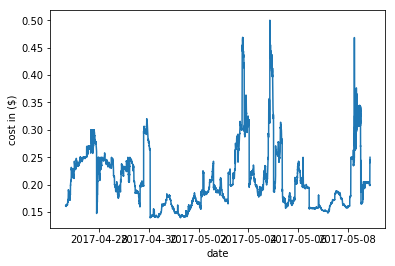

In [1]:
import dateutil.parser
import pandas
import numpy as np
import matplotlib.pyplot as plt
import mpld3

%matplotlib inline
mpld3.enable_notebook()

from IPython.display import display, HTML

# Data format: Time, Instance type, OS, Availability Zone, Current Bid Price
# 2017-05-08 20:14:04+00:00,p2.xlarge,Linux/UNIX,us-west-1b,0.482
dataframe = pandas.read_csv('p2-east-1b.csv', usecols=[0, 4], engine='python', names=['date','cost ($)'])
display(dataframe[:5])
values = dataframe.values[::-1] # reverse to order the dataset chronologically
ticks = map(dateutil.parser.parse, values[:,0]) # get time ticks
dataset = values[:,1] # get spot instance prices
print dataset.shape, type(dataset)
plt.plot(ticks, dataset)
plt.ylabel("cost in ($)")
plt.xlabel("date")
plt.show()
dataset = dataset.astype(np.float32)

## Data Preprocessing: Convert to Sequence, Normalize

In [2]:
import numpy as np
import mxnet as mx
import logging
import sys
from sklearn.preprocessing import MinMaxScaler

# Config the logging
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

# define sequence length
seq_len = 2
timesteps = seq_len
batch_size = 32
data_dim = 5

# normalize the dataset
dataset = np.reshape(dataset, (len(dataset), 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# select the closing price as the label
x = dataset
y = dataset[:, [-1]]

dataX = []
dataY = []

# convert an array of values into a dataset matrix
# reshape into X=t and Y=t+seq_len
for i in range(0, len(y) - seq_len):
    xx = x[i:i + seq_len]
    yy = y[i + seq_len]
    dataX.append(xx)
    dataY.append(yy)
    
print dataX[0], dataY[0] # note that it has seq_len number of elements

[[0.06241331]
 [0.06324551]] [0.0613037]


## Split Dataset and Define Iterators

In [3]:
# divide the data in to training set and test set
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(
    dataX[train_size:len(dataX)]) # continous sequence of datapoints
trainY, testY = np.array(dataY[0:train_size]), np.array(
    dataY[train_size:len(dataY)]) 

# create train and test iterators
train_iter = mx.io.NDArrayIter(data=trainX, label=trainY,
                                   data_name="data", label_name="target",
                                   batch_size=batch_size,
                                   shuffle=True)
test_iter = mx.io.NDArrayIter(data=testX, label=testY,
                                  data_name="data", label_name="target",
                                  batch_size=batch_size)

# Model Definition and Training

In [4]:
# Define the LSTM Neural Network
num_epochs = 20

# Note that when unrolling, if 'merge_outputs' is set to True, 
# the 'outputs' is merged into a single symbol
# In the layout, 'N' represents batch size, 'T' represents sequence length, 
# and 'C' represents the number of dimensions in hidden states.

data = mx.sym.var("data")  # Shape: (N, T, C)
target = mx.sym.var("target")  # Shape: (N, T, C)
data = mx.sym.transpose(data, axes=(1, 0, 2))  # Shape: (T, N, C)

lstm1 = mx.rnn.LSTMCell(num_hidden=5, prefix="lstm1_")
lstm2 = mx.rnn.LSTMCell(num_hidden=10, prefix="lstm2_")

L1, L1_states = lstm1.unroll(length=seq_len, inputs=data, 
                             merge_outputs=True,
                             layout="TNC")  # Shape: (T, N, 5)

L1 = mx.sym.Dropout(L1, p=0.2)  # Shape: (T, N, 5)

L2, L2_states = lstm2.unroll(length=seq_len, inputs=L1, 
                            merge_outputs=True,
                            layout="TNC")  # Shape: (T, N, 10)

L2 = mx.sym.reshape(L2_states[0], shape=(-1, 0), reverse=True)  # Shape: (T * N, 10)
pred = mx.sym.FullyConnected(L2, num_hidden=1, name="pred")
pred = mx.sym.LinearRegressionOutput(data=pred, label=target)

model = mx.mod.Module(symbol=pred, data_names=['data'], 
                    label_names=['target'], context=mx.cpu(0))

model.fit(train_data=train_iter, eval_data=test_iter,
            initializer=mx.init.Xavier(rnd_type="gaussian", magnitude=1),
            optimizer="adam",
            optimizer_params={"learning_rate": 1E-3},
            eval_metric="mse", num_epoch=num_epochs)

INFO:root:Epoch[0] Train-mse=0.030269
INFO:root:Epoch[0] Time cost=0.315
INFO:root:Epoch[0] Validation-mse=0.019290
INFO:root:Epoch[1] Train-mse=0.009716
INFO:root:Epoch[1] Time cost=0.296
INFO:root:Epoch[1] Validation-mse=0.001835
INFO:root:Epoch[2] Train-mse=0.002229
INFO:root:Epoch[2] Time cost=0.332
INFO:root:Epoch[2] Validation-mse=0.001325
INFO:root:Epoch[3] Train-mse=0.001866
INFO:root:Epoch[3] Time cost=0.329
INFO:root:Epoch[3] Validation-mse=0.001290
INFO:root:Epoch[4] Train-mse=0.001649
INFO:root:Epoch[4] Time cost=0.340
INFO:root:Epoch[4] Validation-mse=0.001167
INFO:root:Epoch[5] Train-mse=0.001454
INFO:root:Epoch[5] Time cost=0.351
INFO:root:Epoch[5] Validation-mse=0.001116
INFO:root:Epoch[6] Train-mse=0.001379
INFO:root:Epoch[6] Time cost=0.334
INFO:root:Epoch[6] Validation-mse=0.001091
INFO:root:Epoch[7] Train-mse=0.001203
INFO:root:Epoch[7] Time cost=0.289
INFO:root:Epoch[7] Validation-mse=0.001100
INFO:root:Epoch[8] Train-mse=0.001122
INFO:root:Epoch[8] Time cost=0.310

## Model Prediction and Visualization

Mean Square Loss: 0.001045472


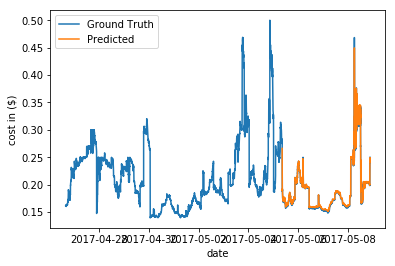

In [5]:
test_predict = model.predict(test_iter).asnumpy()
mse = np.mean((test_predict - testY)**2)
print "Mean Square Loss:", mse

# shift the plot
t_plot = np.empty_like(dataset)
t_plot[:] = np.nan

# lets convert the prediction back to real scale
t_plot[len(trainY):-seq_len] = scaler.inverse_transform(test_predict)

plt.close('all')
fig = plt.figure()
plt.plot(ticks, scaler.inverse_transform(dataset), label='Ground Truth')
plt.plot(ticks, t_plot, label='Predicted')

plt.ylabel("cost in ($)")
plt.xlabel("date")
plt.legend()
plt.show()

# Summary

With just 20 epochs, our two layer LSTM seems to have learnt to predict the next value in the sequence given the previous values (equal to the sequence length). The mean square loss for the validation set is very small incidating high prediction accuracy, which is observed in the resulting graph as well.

# References

Basic LSTM example by hunkim [Github](https://github.com/hunkim/DeepLearningZeroToAll/blob/master/mxnet/mxlab-12-4-rnn_deep_prediction.py)

Understanding [LSTM's](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)